# Fine-tuning and deploying ProtBert Model for Protein Classification using Amazon SageMaker


## Contents
1. [Motivation](#Motivation)
2. [What is ProtBert?](#What-is-ProtBert?)
3. [Notebook Overview](#Notebook-Overview)
    - [Setup](#Setup)
4. [Dataset](#Dataset)
    - [Download Data](#Download-Data)
5. [Data Exploration](#Data-Exploration)
    - [Upload Data to S3](#Upload-Data-to-S3)
6. [Training script](#Training-script)
7. [Train on Amazon SageMaker](#Train-on-Amazon-SageMaker)
8. [Deploy the Model on Amazon SageMaker](#Deploy-the-model-on-Amazon-SageMaker)
    - [Create a model object](#Create-a-model-object)
    - [Deploy the model on an endpoint](#Deploy-the-model-on-an-endpoint)
9. [Predicting SubCellular Localization of Protein Sequences](#Predicting-SubCellular-Localization-of-Protein-Sequences)
10. [References](#References)
---

## Motivation
<img src="https://upload.wikimedia.org/wikipedia/commons/6/60/Myoglobin.png"
     alt="Protein Sequence"
     style="float: left;"
     height = 100
     width = 250/>
**Proteins** are the key fundamental macromolecules governing in biological bodies. The study of protein localization is important to comprehend the function of protein and has great importance for drug design and other applications. It also plays an important role in characterizing the cellular function of hypothetical and newly discovered proteins [1]. There are several research endeavours that aim to localize whole proteomes by using high-throughput approaches [2–4]. These large datasets provide important information about protein function, and more generally global cellular processes. However, they currently do not achieve 100% coverage of proteomes, and the methodology used can in some cases cause mislocalization of subsets of proteins [5,6]. Therefore, complementary methods are necessary to address these problems. In this notebook, we will leverage Natural Language Processing (NLP) techniques for protein sequence classification. The idea is to interpret protein sequences as sentences and their constituent – amino acids –
as single words [7]. More specifically we will fine tune Pytorch ProtBert model from Hugging Face library.

## What is ProtBert?

ProtBert is a pretrained model on protein sequences using a masked language modeling (MLM) objective. It is based on Bert model which is pretrained on a large corpus of protein sequences in a self-supervised fashion. This means it was pretrained on the raw protein sequences only, with no humans labelling them in any way (which is why it can use lots of publicly available data) with an automatic process to generate inputs and labels from those protein sequences [8]. For more information about ProtBert, see [`ProtTrans: Towards Cracking the Language of Life’s Code Through Self-Supervised Deep Learning and High Performance Computing`](https://www.biorxiv.org/content/10.1101/2020.07.12.199554v2.full).

---


## Notebook Overview

This example notebook focuses on fine-tuning the Pytorch ProtBert model and deploying it using Amazon SageMaker, which is the most comprehensive and fully managed machine learning service. With SageMaker, data scientists and developers can quickly and easily build and train machine learning models, and then directly deploy them into a production-ready hosted environment. 
During the training, we will leverage SageMaker distributed data parallel (SDP) feature which extends SageMaker’s training capabilities on deep learning models with near-linear scaling efficiency, achieving fast time-to-train with minimal code changes.

_**Note**_: Please select the Kernel as ` Python 3 (Pytorch 1.6 Python 3.6 CPU Optimized)`.

---

### Setup

To start, we import some Python libraries and initialize a SageMaker session, S3 bucket and prefix, and IAM role.


In [1]:
!pip install --upgrade pip -q
!pip install -U boto3 sagemaker -q
!pip install seaborn -q

Next let us import the common libraries needed for the operations done later.

In [2]:
import re
import json
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import numpy as np
import pandas as pd
import sagemaker
import torch
import seaborn as sns
import matplotlib.pyplot as plt

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

Next, let's verify the version, create a SageMaker session and get the execution role which is the IAM role arn used to give training and hosting access to your data.

In [3]:
import sagemaker
print(sagemaker.__version__)
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

2.23.0


Now we will specify the S3 bucket and prefix where you will store your training data and model artifacts. This should be within the same region as the Notebook Instance, training, and hosting.

In [4]:
bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/DEMO-pytorch-bert"

role = sagemaker.get_execution_role()

As the last step of setting up the enviroment lets set a value to a random seed so that we cna reproduce the same results later.

In [5]:
RANDOM_SEED = 43
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

---

## Dataset

We are going to use a opensource public dataset of protein sequences available [here](http://www.cbs.dtu.dk/services/DeepLoc-1.0/data.php). The dataset is a `fasta file` composed by header and protein sequence. The header is composed by the accession number from Uniprot, the annotated subcellular localization and possibly a description field indicating if the protein was part of the test set. The subcellular localization includes an additional label, where S indicates soluble, M membrane and U unknown[9].
Sample of the data is as follows :

```
>Q9SMX3 Mitochondrion-M test
MVKGPGLYTEIGKKARDLLYRDYQGDQKFSVTTYSSTGVAITTTGTNKGSLFLGDVATQVKNNNFTADVKVST
DSSLLTTLTFDEPAPGLKVIVQAKLPDHKSGKAEVQYFHDYAGISTSVGFTATPIVNFSGVVGTNGLSLGTDV
AYNTESGNFKHFNAGFNFTKDDLTASLILNDKGEKLNASYYQIVSPSTVVGAEISHNFTTKENAITVGTQHAL>
DPLTTVKARVNNAGVANALIQHEWRPKSFFTVSGEVDSKAIDKSAKVGIALALKP"
```

A sequence in FASTA format begins with a single-line description, followed by lines of sequence data. The definition line (defline) is distinguished from the sequence data by a greater-than (>) symbol at the beginning. The word following the ">" symbol is the identifier of the sequence, and the rest of the line is the description.

### Download Data

In [6]:
!wget http://www.cbs.dtu.dk/services/DeepLoc-1.0/deeploc_data.fasta -P ./data -q

Since the data is in fasta format, we can leverage `Bio.SeqIO.FastaIO` library to read the dataset. Let us install the Bio package.

In [7]:
!pip install Bio -q
import Bio

Using the Bio package we will read the data directly by filtering out the columns that are of interest. We will also add a space seperater between each character in the sequence field which will be useful during model training.

In [8]:
def read_fasta(file_path, columns) :
    from Bio.SeqIO.FastaIO import SimpleFastaParser
    with open('./data/deeploc_data.fasta') as fasta_file:  # Will close handle cleanly
        records = []
        for title, sequence in SimpleFastaParser(fasta_file):
            record = []
            title_splits = title.split(None)
            record.append(title_splits[0])  # First word is ID
            sequence = " ".join(sequence)
            record.append(sequence)
            record.append(len(sequence))
            location_splits = title_splits[1].split("-")
            record.append(location_splits[0])  # Second word is Location
            record.append(location_splits[1])  # Second word is Membrane

            if(len(title_splits) > 2):
                record.append(0)
            else:
                record.append(1)
                
            records.append(record)
    return pd.DataFrame(records, columns = columns)
        
data = read_fasta("./tmp/deeploc_data.fasta", columns=["id", "sequence", "sequence_length", "location", "membrane", "is_train"])
data.head()

,id,sequence,sequence_length,location,membrane,is_train
0,Q9H400,M G L P V S W A P P A L W V L G C C A L L L S ...,589,Cell.membrane,M,0
1,Q5I0E9,M E V L E E P A P G P G G A D A A E R R G L R ...,1131,Cell.membrane,M,1
2,P63033,M M K T L S S G N C T L N V P A K N S Y R M V ...,531,Cell.membrane,M,1
3,Q9NR71,M A K R T F S N L E T F L I F L L V M M S A I ...,1559,Cell.membrane,M,1
4,Q86XT9,M G N C Q A G H N L H L C L A H H P P L V C A ...,479,Cell.membrane,M,1


### Data Exploration
Dataset consists of 14K sequences and 6 columns in total. We will only use the following columns during training:

* _**id**_ : Unique identifier given each sequence in the dataset.
* _**sequence**_ : Protein sequence. Each character is seperated by a "space". Will be useful for BERT tokernizer.
* _**sequence_length**_ : Character length of each protein sequence. 
* _**location**_ : Classification given each sequence.
* _**is_train**_ : Indicates whether the record be used for training or test. Will be used to seperate the dataset for traning and validation.


First, let's verify if there are any missing values in the dataset.

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14004 entries, 0 to 14003
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               14004 non-null  object
 1   sequence         14004 non-null  object
 2   sequence_length  14004 non-null  int64 
 3   location         14004 non-null  object
 4   membrane         14004 non-null  object
 5   is_train         14004 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 656.6+ KB


In [10]:
data.isnull().values.any()

False

As you can see, there are **no** missing values in this dataset. 

Second, we will see the number of available classes (subcellular localization), which will be used for protein classification. 

In [11]:
unique_classes = data.location.unique()
print("Number of classes: ", len(unique_classes))
unique_classes

Number of classes:  10


array(['Cell.membrane', 'Cytoplasm', 'Endoplasmic.reticulum',
       'Golgi.apparatus', 'Lysosome/Vacuole', 'Mitochondrion', 'Nucleus',
       'Peroxisome', 'Plastid', 'Extracellular'], dtype=object)

We can see that there are 10 unique classes in the dataset.

Third, lets check the sequence length.

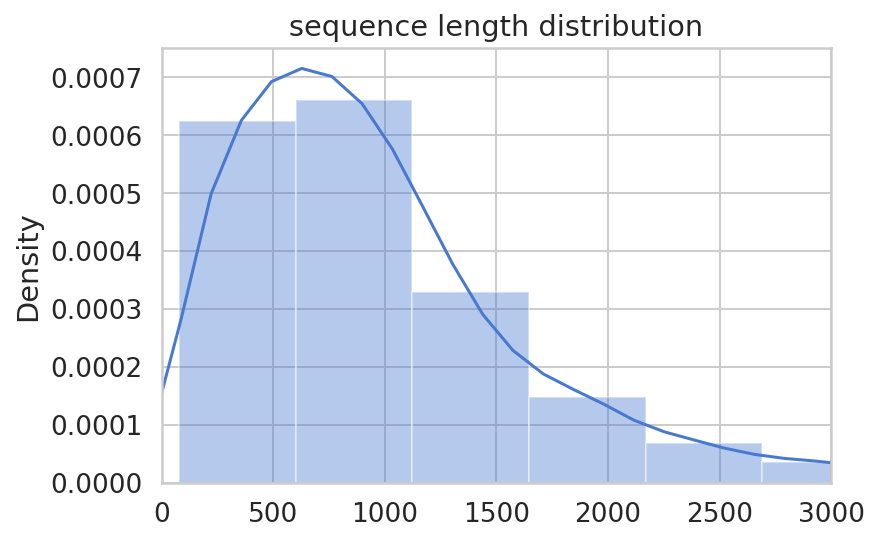

In [12]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
ax = sns.distplot(data['sequence_length'].values)
ax.set_xlim(0, 3000)
plt.title(f'sequence length distribution')
plt.grid(True)

This is an important observation as PROTBERT model receives a fixed length of sentence as input. Usually the maximum length of a sentence depends on the data we are working on. For sentences that are shorter than this maximum length, we will have to add paddings (empty tokens) to the sentences to make up the length.

As you can see from the above plot that most of the sequences lie under the length of around 1500, therefore, its a good idea to select the `max_length = 1536` but that will increase the training time for this sample notebook, therefore, we will use `max_length = 512`. You can experiment it with the bigger length and it does improves the accuracy as most of the subcellular localization information of protiens is stored at the end of the sequence. 

Next let's factorize the protein classes. 

In [13]:
categories = data.location.astype('category').cat
data['location'] = categories.codes
class_names = categories.categories
num_classes = len(class_names)
print(class_names)

Index(['Cell.membrane', 'Cytoplasm', 'Endoplasmic.reticulum', 'Extracellular',
       'Golgi.apparatus', 'Lysosome/Vacuole', 'Mitochondrion', 'Nucleus',
       'Peroxisome', 'Plastid'],
      dtype='object')


Next, let's devide the dataset into training and test. We can leverage the `is_train` column to do the split. 

In [14]:
df_train = data[data.is_train == 1]
df_train = df_train.drop(["is_train"], axis = 1)
df_train.shape[0]

11231

In [15]:
df_test = data[data.is_train == 0]
df_test = df_test.drop(["is_train"], axis = 1)
df_test.shape[0]

2773

We got **11231** records as training set and **2773** records as the test set which is about 75:25 data split between the train and test. Also, the composition between multiple classes remains uniform between both datasets. 

### Upload Data to S3
In order to accomodate model training on SageMaker we need to upload the data to s3 location. We are going to use the `sagemaker.Session.upload_data` function to upload our datasets to an S3 location. The return value inputs identifies the location -- we will use later when we start the training job.

In [16]:
train_dataset_path = './data/deeploc_per_protein_train.csv'
test_dataset_path = './data/deeploc_per_protein_test.csv'
df_train.to_csv(train_dataset_path)
df_test.to_csv(test_dataset_path)
inputs_train = sagemaker_session.upload_data(train_dataset_path, bucket=bucket, key_prefix=prefix)
inputs_test = sagemaker_session.upload_data(test_dataset_path, bucket=bucket, key_prefix=prefix)

In [17]:
print("S3 location for training data: ", inputs_train )
print("S3 location for testing data: ", inputs_test )

S3 location for training data:  s3://sagemaker-us-west-2-706553727873/sagemaker/DEMO-pytorch-bert/deeploc_per_protein_train.csv
S3 location for testing data:  s3://sagemaker-us-west-2-706553727873/sagemaker/DEMO-pytorch-bert/deeploc_per_protein_test.csv


## Training script
We use the [PyTorch-Transformers library](https://pytorch.org/hub/huggingface_pytorch-transformers), which contains PyTorch implementations and pre-trained model weights for many NLP models, including BERT. As mentioned above, we will use `ProtBert model` which is pre-trained on protein sequences. 

Our training script should save model artifacts learned during training to a file path called `model_dir`, as stipulated by the SageMaker PyTorch image. Upon completion of training, model artifacts saved in `model_dir` will be uploaded to S3 by SageMaker and will be used for deployment.

We save this script in a file named `train.py`, and put the file in a directory named `code/`. The full training script can be viewed under `code/`.

It also has the code required for distributed data parallel (DDP) training using SMDataParallel. It is very similar to a PyTorch training script you might run outside of SageMaker, but modified to run with SMDataParallel, which is a new capability in Amazon SageMaker to train deep learning models faster and cheaper. SMDataParallel's PyTorch client provides an alternative to PyTorch's native DDP. For details about how to use SMDataParallel's DDP in your native PyTorch script, see the [Getting Started with SMDataParallel tutorials](https://docs.aws.amazon.com/sagemaker/latest/dg/distributed-training.html#distributed-training-get-started).

In [18]:
!pygmentize code/train.py

from __future__ import print_function

import argparse
import json
import logging
import os
import sys

import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.utils.data
import torch.utils.data.distributed
from torch.utils.data import Dataset, DataLoader, RandomSampler, TensorDataset
from transformers import BertTokenizer, get_linear_schedule_with_warmup
import torch_optimizer as optim

# Network definition
from model_def import ProteinClassifier
from data_prep import ProteinSequenceDataset
 
## SageMaker Distributed code.
from smdistributed.dataparallel.torch.parallel.distributed import DistributedDataParallel as DDP
import smdistributed.dataparallel.torch.distributed as dist

dist.init_process_group()

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

MAX_LEN = 512  # this is the max length of the sequence
PRE_TRAINED_MODEL_NAME = 'Rostlab/prot_bert'
tokenizer = BertTokenizer.from_p

### Train on Amazon SageMaker
We use Amazon SageMaker to train and deploy a model using our custom PyTorch code. The Amazon SageMaker Python SDK makes it easier to run a PyTorch script in Amazon SageMaker using its PyTorch estimator. After that, we can use the SageMaker Python SDK to deploy the trained model and run predictions. For more information on how to use this SDK with PyTorch, see [the SageMaker Python SDK documentation](https://sagemaker.readthedocs.io/en/stable/using_pytorch.html).

To start, we use the `PyTorch` estimator class to train our model. When creating our estimator, we make sure to specify a few things:

* `entry_point`: the name of our PyTorch script. It contains our training script, which loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model. It also contains code to load and run the model during inference.
* `source_dir`: the location of our training scripts and requirements.txt file. "requirements.txt" lists packages you want to use with your script.
* `framework_version`: the PyTorch version we want to use.

The PyTorch estimator supports both single-machine & multi-machine, distributed PyTorch training using SMDataParallel. _Our training script supports distributed training for only GPU instances_. 

#### Instance types

SMDataParallel supports model training on SageMaker with the following instance types only:

- ml.p3.16xlarge
- ml.p3dn.24xlarge [Recommended]
- ml.p4d.24xlarge [Recommended]

#### Instance count

To get the best performance and the most out of SMDataParallel, you should use at least 2 instances, but you can also use 1 for testing this example.

#### Distribution strategy

Note that to use DDP mode, you update the the distribution strategy, and set it to use smdistributed dataparallel.

After creating the estimator, we then call fit(), which launches a training job. We use the Amazon S3 URIs where we uploaded the training data earlier.

In [19]:
# Training job will take around 20-25 mins to execute. 

from sagemaker.pytorch import PyTorch


TRAINING_JOB_NAME="protbert-training-pytorch-{}".format(time.strftime("%m-%d-%Y-%H-%M-%S")) 
print('Training job name: ', TRAINING_JOB_NAME)

estimator = PyTorch(
    entry_point="train.py",
    source_dir="code",
    role=role,
    framework_version="1.6.0",
    py_version="py36",
    instance_count=1,  # this script support distributed training for only GPU instances.
    instance_type="ml.p3.16xlarge",
    distribution={'smdistributed':{
        'dataparallel':{
            'enabled': True
        }
    }
                 },
    debugger_hook_config=False,
    hyperparameters={
        "epochs": 3,
        "num_labels": num_classes,
        "batch-size": 4,
        "test-batch-size": 4,
        "log-interval": 100,
        "frozen_layers": 15,
    },
    metric_definitions=[
                   {'Name': 'train:loss', 'Regex': 'Training Loss: ([0-9\\.]+)'},
                   {'Name': 'test:accuracy', 'Regex': 'Validation Accuracy: ([0-9\\.]+)'},
                   {'Name': 'test:loss', 'Regex': 'Validation loss: ([0-9\\.]+)'},
                ]
)
estimator.fit({"training": inputs_train, "testing": inputs_test}, job_name=TRAINING_JOB_NAME)

Training job name:  protbert-training-pytorch-12-29-2020-03-43-47
2020-12-29 03:43:48 Starting - Starting the training job...
2020-12-29 03:44:11 Starting - Launching requested ML instancesProfilerReport-1609213427: InProgress
.........
2020-12-29 03:45:48 Starting - Preparing the instances for training............
2020-12-29 03:47:45 Downloading - Downloading input data
2020-12-29 03:47:45 Training - Downloading the training image.....................
2020-12-29 03:51:17 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-12-29 03:51:05,719 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2020-12-29 03:51:05,798 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-12-29 03:51:08,826 sagemaker_pytorch_container.training INFO     Invoking SMDataParallel
2020-12-29 03:51:08,82

With `max_length=512` and running the model for only 3 epochs we get the validation accuracy of around 65%, which is pretty decent. You can optimize it further by trying bigger sequence length, increasing the number of epochs and tuning other hyperparamters. For details you can refer to the research paper: 
[`ProtTrans: Towards Cracking the Language of Life’s Code Through Self-Supervised Deep Learning and High Performance Computing`](https://arxiv.org/pdf/2007.06225.pdf).

Before, we deploy the model to an endpoint, let's first store the model to S3.

In [20]:
model_data = estimator.model_data
print("Storing {} as model_data".format(model_data))
%store model_data

Storing s3://sagemaker-us-west-2-706553727873/protbert-training-pytorch-12-29-2020-03-43-47/output/model.tar.gz as model_data
Stored 'model_data' (str)


In [21]:
%store -r model_data

# If no model was found, set it manually here.
# model_data = 's3://sagemaker-{region}-XXX/protbert-training-pytorch-XX-XX-XXXX-XX-XX-XX/output/model.tar.gz'

print("Using this model: {}".format(model_data))

Using this model: s3://sagemaker-us-west-2-706553727873/protbert-training-pytorch-12-29-2020-03-43-47/output/model.tar.gz


## Deploy the model on Amazon SageMaker

After training our model, we host it on an Amazon SageMaker Endpoint. To make the endpoint load the model and serve predictions, we implement a few methods in inference.py.

- `model_fn()`: function defined to load the saved model and return a model object that can be used for model serving. The SageMaker PyTorch model server loads our model by invoking model_fn.
- `input_fn()`: deserializes and prepares the prediction input. In this example, our request body is first serialized to JSON and then sent to model serving endpoint. Therefore, in input_fn(), we first deserialize the JSON-formatted request body and return the input as a torch.tensor, as required for BERT.
- `predict_fn()`: performs the prediction and returns the result.
To deploy our endpoint, we call deploy() on our PyTorch estimator object, passing in our desired number of instances and instance type:

### Create a model object
You define the model object by using SageMaker SDK's PyTorchModel and pass in the model from the estimator and the entry_point.  The function loads the model and sets it to use a GPU, if available.

In [22]:
import sagemaker
role = sagemaker.get_execution_role()

from sagemaker.pytorch import PyTorchModel
ENDPOINT_NAME = "protbert-inference-pytorch-1-{}".format(time.strftime("%m-%d-%Y-%H-%M-%S"))
print("Endpoint name: ", ENDPOINT_NAME)
model = PyTorchModel(model_data=model_data, source_dir='code',
                        entry_point='inference.py', role=role, framework_version='1.6.0', py_version='py3')

Endpoint name:  protbert-inference-pytorch-1-12-29-2020-04-24-26


### Deploy the model on an endpoint
You create a predictor by using the model.deploy function. You can optionally change both the instance count and instance type.

In [23]:
%%time
predictor = model.deploy(initial_instance_count=1, instance_type='ml.m5.2xlarge', endpoint_name=ENDPOINT_NAME)

------------------!CPU times: user 1min 46s, sys: 15.9 s, total: 2min 2s
Wall time: 10min 48s


## Predicting SubCellular Localization of Protein Sequences

In [24]:
import boto3

runtime= boto3.client('runtime.sagemaker')
client = boto3.client('sagemaker')

endpoint_desc = client.describe_endpoint(EndpointName=ENDPOINT_NAME)
print(endpoint_desc)
print('---'*30)

{'EndpointName': 'protbert-inference-pytorch-1-12-29-2020-04-24-26', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:706553727873:endpoint/protbert-inference-pytorch-1-12-29-2020-04-24-26', 'EndpointConfigName': 'protbert-inference-pytorch-1-12-29-2020-04-24-26', 'ProductionVariants': [{'VariantName': 'AllTraffic', 'DeployedImages': [{'SpecifiedImage': '763104351884.dkr.ecr.us-west-2.amazonaws.com/pytorch-inference:1.6.0-cpu-py3', 'ResolvedImage': '763104351884.dkr.ecr.us-west-2.amazonaws.com/pytorch-inference@sha256:ebefc48d8ae61af50559182e29acf874a05d8caebb77ba03a13a84a55f5d534f', 'ResolutionTime': datetime.datetime(2020, 12, 29, 4, 26, 18, 30000, tzinfo=tzlocal())}], 'CurrentWeight': 1.0, 'DesiredWeight': 1.0, 'CurrentInstanceCount': 1, 'DesiredInstanceCount': 1}], 'EndpointStatus': 'InService', 'CreationTime': datetime.datetime(2020, 12, 29, 4, 26, 13, 698000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2020, 12, 29, 4, 34, 53, 22000, tzinfo=tzlocal()), 'ResponseMetadata':

We then configure the predictor to use application/json for the content type when sending requests to our endpoint:

In [25]:
predictor.serializer = sagemaker.serializers.JSONSerializer()
predictor.deserializer = sagemaker.deserializers.JSONDeserializer()

Finally, we use the returned predictor object to call the endpoint:

In [26]:
protein_sequence = 'M G K K D A S T T R T P V D Q Y R K Q I G R Q D Y K K N K P V L K A T R L K A E A K K A A I G I K E V I L V T I A I L V L L F A F Y A F F F L N L T K T D I Y E D S N N'
prediction = predictor.predict(protein_sequence)
print(prediction)
print(f'Protein Sequence: {protein_sequence}')
print("Sequence Localization Ground Truth is: {} - prediction is: {}".format('Endoplasmic.reticulum', class_names[prediction[0]]))

[2]
Protein Sequence: M G K K D A S T T R T P V D Q Y R K Q I G R Q D Y K K N K P V L K A T R L K A E A K K A A I G I K E V I L V T I A I L V L L F A F Y A F F F L N L T K T D I Y E D S N N
Sequence Localization Ground Truth is: Endoplasmic.reticulum - prediction is: Endoplasmic.reticulum


In [27]:
protein_sequence = 'M S M T I L P L E L I D K C I G S N L W V I M K S E R E F A G T L V G F D D Y V N I V L K D V T E Y D T V T G V T E K H S E M L L N G N G M C M L I P G G K P E'
prediction = predictor.predict(protein_sequence)
print(prediction)
print(f'Protein Sequence: {protein_sequence}')
print("Sequence Localization Ground Truth is: {} - prediction is: {}".format('Nucleus', class_names[prediction[0]]))

[7]
Protein Sequence: M S M T I L P L E L I D K C I G S N L W V I M K S E R E F A G T L V G F D D Y V N I V L K D V T E Y D T V T G V T E K H S E M L L N G N G M C M L I P G G K P E
Sequence Localization Ground Truth is: Nucleus - prediction is: Nucleus


In [28]:
seq = 'M G G P T R R H Q E E G S A E C L G G P S T R A A P G P G L R D F H F T T A G P S K A D R L G D A A Q I H R E R M R P V Q C G D G S G E R V F L Q S P G S I G T L Y I R L D L N S Q R S T C C C L L N A G T K G M C'
prediction = predictor.predict(seq)
print(prediction)
print(f'Protein Sequence: {seq}')
print("Sequence Localization Ground Truth is: {} - prediction is: {}".format('Cytoplasm',class_names[prediction[0]]))

[1]
Protein Sequence: M G G P T R R H Q E E G S A E C L G G P S T R A A P G P G L R D F H F T T A G P S K A D R L G D A A Q I H R E R M R P V Q C G D G S G E R V F L Q S P G S I G T L Y I R L D L N S Q R S T C C C L L N A G T K G M C
Sequence Localization Ground Truth is: Cytoplasm - prediction is: Cytoplasm


# Cleanup

Lastly, please remember to delete the Amazon SageMaker endpoint to avoid charges:

In [29]:
predictor.delete_endpoint()

## References
- [1] Refining Protein Subcellular Localization (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1289393/)
- [2] Kumar A, Agarwal S, Heyman JA, Matson S, Heidtman M, et al. Subcellular localization of the yeast proteome. Genes Dev. 2002;16:707–719. [PMC free article] [PubMed] [Google Scholar]
- [3] Huh WK, Falvo JV, Gerke LC, Carroll AS, Howson RW, et al. Global analysis of protein localization in budding yeast. Nature. 2003;425:686–691. [PubMed] [Google Scholar]
- [4] Wiemann S, Arlt D, Huber W, Wellenreuther R, Schleeger S, et al. From ORFeome to biology: A functional genomics pipeline. Genome Res. 2004;14:2136–2144. [PMC free article] [PubMed] [Google Scholar]
- [5] Davis TN. Protein localization in proteomics. Curr Opin Chem Biol. 2004;8:49–53. [PubMed] [Google Scholar]
- [6] Scott MS, Thomas DY, Hallett MT. Predicting subcellular localization via protein motif co-occurrence. Genome Res. 2004;14:1957–1966. [PMC free article] [PubMed] [Google Scholar]
- [7] ProtTrans: Towards Cracking the Language of Life's Code Through Self-Supervised Deep Learning and High Performance Computing (https://www.biorxiv.org/content/10.1101/2020.07.12.199554v2.full.pdf)
- [8] ProtBert Hugging Face (https://huggingface.co/Rostlab/prot_bert)
- [9] DeepLoc-1.0: Eukaryotic protein subcellular localization predictor (http://www.cbs.dtu.dk/services/DeepLoc-1.0/data.php)